# Lake model continued

In the previous week you used the lake problem as a means of getting aquinted with the workbench. In this assignment we will continue with the lake problem, focussing explicitly on using it for open exploration. You can use the second part of [this tutorial](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html) for help.

**It is paramount that you are using the lake problem with 100 decision variables, rather than the one found on the website with the seperate anthropogenic release decision**

## Apply sensitivity analysis
There is substantial support in the ema_workbench for global sensitivity. For this, the workbench relies on [SALib](https://salib.readthedocs.io/en/latest/) and feature scoring which is a machine learning alternative for global sensitivity analysis. 


1. Apply Sobol with 3 seperate release policies (0, 0.05, and 0.1) and analyse the results for each release policy seperately focusing on the reliability objective. Do the sensitivities change depending on the release policy? Can you explain why or why not?

*hint: you can use sobol sampling for the uncertainties, and set policies to a list with the 3 different release policies. Next, for the analysis using logical indexing on the experiment.policy column you can select the results for each seperate release policy and apply sobol to each of the three seperate release policies. If this sounds too complicated, just do it on each release policy seperately.*



2. Repeat the above analysis for the 3 release policies but now with extra trees feature scoring and for all outcomes of interest. As a bonus, use the sobol experiment results as input for extra trees, and compare the results with those resulting from latin hypercube sampling.

*hint: you can use [seaborn heatmaps](https://seaborn.pydata.org/generated/seaborn.heatmap.html) for a nice figure of the results*


In [20]:
from lakemodel_function import lake_problem

from ema_workbench import (Model, RealParameter, ScalarOutcome, MultiprocessingEvaluator)

#instantiate the model
lake_model = Model('lakeproblem', function=lake_problem)
lake_model.time_horizon = 100 # used to specify the number of timesteps

#specify uncertainties
lake_model.uncertainties = [RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('delta', 0.93, 0.99)]

# set levers, one for each time step
lake_model.levers = [RealParameter(f"l{i}", 0, 0.1) for i in 
                     range(lake_model.time_horizon)] # we use time_horizon here

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P'),
                       ScalarOutcome('utility'),
                       ScalarOutcome('inertia'),
                       ScalarOutcome('reliability')]

In [64]:
from ema_workbench import Policy, perform_experiments
from ema_workbench import ema_logging
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from statistics import mean
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

ema_logging.log_to_stderr(ema_logging.INFO)



<Logger EMA (DEBUG)>

In [18]:
 # add policies
policies = [Policy('no policy',
                      **{l.name:0 for l in lake_model.levers}),
            Policy('small release',
                       **{l.name:0.05 for l in lake_model.levers}),
            Policy('large release',
                       **{l.name:0.1 for l in lake_model.levers})
                ]

# Part 1 sobol

In [24]:
%%time
n_scenarios = 1000

results = perform_experiments(lake_model, n_scenarios, policies=policies, uncertainty_sampling='sobol')
experiments, outcomes = results


[MainProcess/INFO] performing 12000 scenarios * 3 policies * 1 model(s) = 36000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 7200 cases completed
[MainProcess/INFO] 10800 cases completed
[MainProcess/INFO] 14400 cases completed
[MainProcess/INFO] 18000 cases completed
[MainProcess/INFO] 21600 cases completed
[MainProcess/INFO] 25200 cases completed
[MainProcess/INFO] 28800 cases completed
[MainProcess/INFO] 32400 cases completed
[MainProcess/INFO] 36000 cases completed
[MainProcess/INFO] experiments finished


In [59]:
problem = get_SALib_problem(lake_model.uncertainties)
reliability = outcomes['reliability']

# Slice per policy
no_policy_experiments = experiments[0:1200]
no_policy_reliability = reliability[0:1200]


small_release_experiments = experiments[1200:2400]
small_release_reliability = reliability[1200:2400]

large_release_experiments = experiments[2400:3600]
large_release_reliability = reliability[2400:3600]

Si_no_policy = sobol.analyze(problem, no_policy_reliability,
                       calc_second_order=True, print_to_console=False)

Si_small_release = sobol.analyze(problem, small_release_reliability,
                       calc_second_order=True, print_to_console=False)

Si_large_release = sobol.analyze(problem, large_release_reliability,
                       calc_second_order=True, print_to_console=False)


In [71]:
problem

{'num_vars': 5,
 'names': ['b', 'delta', 'mean', 'q', 'stdev'],
 'bounds': [(0.1, 0.45),
  (0.93, 0.99),
  (0.01, 0.05),
  (2.0, 4.5),
  (0.001, 0.005)]}

### No Policy

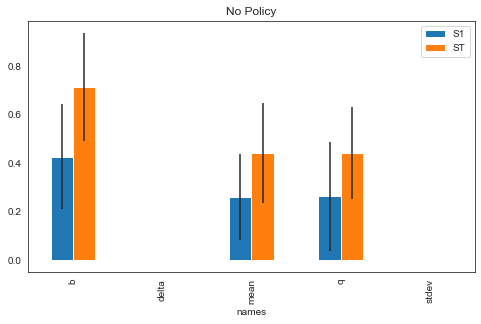

In [109]:

scores_filtered_no_policy = {k:Si_no_policy[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_no_policy_plot = pd.DataFrame(scores_filtered_no_policy)

Si_no_policy_plot["names"] = problem["names"]
Si_no_policy_plot = Si_no_policy_plot.set_index("names")

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_no_policy_plot[['S1','ST']]
err = Si_no_policy_plot[['S1_conf','ST_conf']]

ax.set_title("No Policy")

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

In [100]:
Si_no_policy_plot

,ST,ST_conf,S1,S1_conf
names,,,,
b,0.715210,0.224574,0.426147,0.216579
delta,0.000002,0.000001,-0.000055,0.000269
mean,0.443011,0.206157,0.261608,0.177400
q,0.441769,0.191269,0.262768,0.226793
stdev,0.000013,0.000012,0.000045,0.000627


### Small release policy

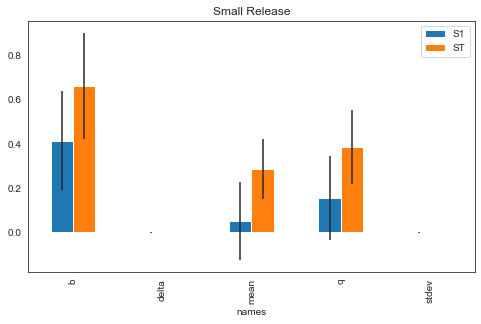

In [101]:
scores_filtered_small_release = {k:Si_small_release[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_small_release_plot = pd.DataFrame(scores_filtered_small_release)

Si_small_release_plot["names"] = problem["names"]
Si_small_release_plot = Si_small_release_plot.set_index("names")

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_small_release_plot[['S1','ST']]
err = Si_small_release_plot[['S1_conf','ST_conf']]

ax.set_title("Small Release")

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

In [102]:
Si_small_release_plot

,ST,ST_conf,S1,S1_conf
names,,,,
b,0.662050,0.241774,0.414539,0.224176
delta,0.000007,0.000006,0.000199,0.000941
mean,0.286252,0.136551,0.051014,0.177223
q,0.385931,0.168235,0.155780,0.189860
stdev,0.000021,0.000023,0.000224,0.001951


### Large release policy

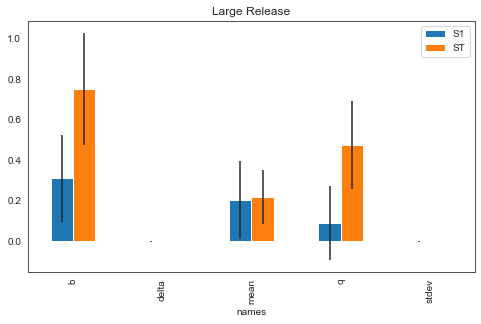

In [112]:
scores_filtered_large_release = {k:Si_large_release[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_large_release_plot = pd.DataFrame(scores_filtered_large_release)

Si_large_release_plot["names"] = problem["names"]
Si_large_release_plot = Si_large_release_plot.set_index("names")

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_large_release_plot[['S1','ST']]
err = Si_large_release_plot[['S1_conf','ST_conf']]

ax.set_title("Large Release")

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

In [133]:
Si_large_release

{'S1': array([3.11153079e-01, 2.80506916e-04, 2.03045733e-01, 8.96884925e-02,
        1.10697243e-03]),
 'S1_conf': array([0.21546399, 0.00070172, 0.19205361, 0.18249475, 0.00183051]),
 'ST': array([7.53561851e-01, 2.18331717e-05, 2.17685852e-01, 4.75810565e-01,
        1.99954276e-04]),
 'ST_conf': array([2.76546818e-01, 3.08992268e-05, 1.33198689e-01, 2.19020619e-01,
        3.47458812e-04]),
 'S2': array([[        nan,  0.08769602,  0.09729056,  0.14728407,  0.08701559],
        [        nan,         nan, -0.00070083, -0.00068656, -0.00066746],
        [        nan,         nan,         nan, -0.03066068, -0.08624314],
        [        nan,         nan,         nan,         nan,  0.03397638],
        [        nan,         nan,         nan,         nan,         nan]]),
 'S2_conf': array([[       nan, 0.32018341, 0.38056345, 0.36676617, 0.31960758],
        [       nan,        nan, 0.00119074, 0.00124486, 0.0011555 ],
        [       nan,        nan,        nan, 0.23518784, 0.20286698]

In [113]:
Si_large_release_plot

,ST,ST_conf,S1,S1_conf
names,,,,
b,0.753562,0.276547,0.311153,0.215464
delta,0.000022,0.000031,0.000281,0.000702
mean,0.217686,0.133199,0.203046,0.192054
q,0.475811,0.219021,0.089688,0.182495
stdev,0.000200,0.000347,0.001107,0.001831


# Part 2 extra trees feature scoring

In [126]:
n_scenarios = 100

trees_results = perform_experiments(lake_model, n_scenarios, policies=policies)
trees_experiments, trees_outcomes = trees_results

[MainProcess/INFO] performing 100 scenarios * 3 policies * 1 model(s) = 300 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] 120 cases completed
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] 180 cases completed
[MainProcess/INFO] 210 cases completed
[MainProcess/INFO] 240 cases completed
[MainProcess/INFO] 270 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] experiments finished


In [127]:
trees_experiments

,b,delta,mean,q,stdev,l0,l1,l2,l3,l4,...,l93,l94,l95,l96,l97,l98,l99,scenario,policy,model
0,0.183580,0.968033,0.042975,2.396833,0.004018,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13400,no policy,lakeproblem
1,0.419417,0.987355,0.029064,2.853366,0.001645,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13401,no policy,lakeproblem
2,0.284330,0.977201,0.042588,2.524852,0.003737,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13402,no policy,lakeproblem
3,0.175404,0.950378,0.048177,3.703401,0.002432,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13403,no policy,lakeproblem
4,0.423722,0.982631,0.043357,4.377262,0.004789,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13404,no policy,lakeproblem
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.103255,0.970369,0.013400,3.533033,0.002011,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,13495,large release,lakeproblem
296,0.184335,0.950715,0.034713,3.310865,0.001335,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,13496,large release,lakeproblem
297,0.165526,0.985709,0.020924,3.399273,0.001112,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,13497,large release,lakeproblem
298,0.335159,0.944423,0.026553,2.279840,0.002711,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,13498,large release,lakeproblem


In [150]:
# Create subsets of the trees outcomes per policy
trees_no_policy_outcomes = dict()
trees_small_release_outcomes = dict()
trees_large_release_outcomes = dict()

for sub in trees_outcomes: 
    # slicing and reassigning
    trees_no_policy_outcomes[sub] = trees_outcomes[sub][0:100]
    trees_small_release_outcomes[sub] = trees_outcomes[sub][100:200]
    trees_large_release_outcomes[sub] = trees_outcomes[sub][200:300]

In [143]:
uncertainties_experiments = trees_experiments[["b", "delta", "mean", "q", "stdev"]]

### No Policy

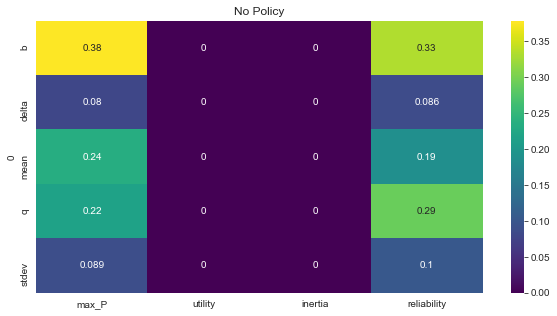

In [151]:
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType

x_no_policy = uncertainties_experiments[0:100]
y_no_policy = trees_no_policy_outcomes

fs = feature_scoring.get_feature_scores_all(x_no_policy, y_no_policy, alg='extra trees', nr_trees=110, max_features=0.6,mode=RuleInductionType.REGRESSION)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_title("No Policy")

sns.heatmap(fs, cmap='viridis', annot=True, ax=ax)

plt.show()

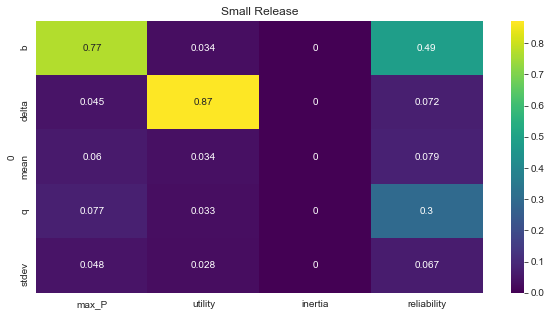

In [153]:
x_small_release = uncertainties_experiments[100:200]
y_small_release = trees_small_release_outcomes

fs = feature_scoring.get_feature_scores_all(x_small_release, y_small_release, alg='extra trees', nr_trees=110, max_features=0.6,mode=RuleInductionType.REGRESSION)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_title("Small Release")

sns.heatmap(fs, cmap='viridis', annot=True, ax=ax)

plt.show()

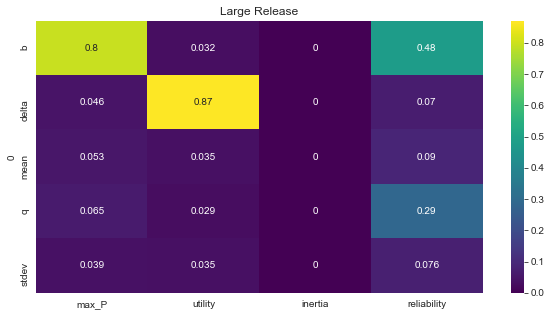

In [154]:
x_large_release = uncertainties_experiments[200:300]
y_large_release = trees_large_release_outcomes

fs = feature_scoring.get_feature_scores_all(x_large_release, y_large_release, alg='extra trees', nr_trees=110, max_features=0.6,mode=RuleInductionType.REGRESSION)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_title("Large Release")

sns.heatmap(fs, cmap='viridis', annot=True, ax=ax)

plt.show()